In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import average_precision_score, precision_score, \
                        recall_score, precision_recall_curve, roc_curve, \
                        roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle



# I prepared these libraries for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from andrea_models import subsample
from visualization import silhouette_diagram, plot_conf_mat, \
                      false_positive_rate, evaluate_anomaly_detector



# To show time at each cell
# Credits to https://medium.com/@arptoth/how-to-measure-execution-time-in-google-colab-707cc9aad1c8
!pip install ipython-autotime 
%load_ext autotime

--2022-02-21 06:30:12--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py.1’

andrea_models.py.1  100%[===================>]   3.12K  --.-KB/s    in 0s      

2022-02-21 06:30:12 (58.2 MB/s) - ‘andrea_models.py.1’ saved [3190/3190]

--2022-02-21 06:30:12--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.


In [6]:
np.random.seed(9)
random.seed(9) 

time: 1.15 ms (started: 2022-02-21 06:30:15 +00:00)


In [7]:
path = "https://raw.githubusercontent.com/Werner-DB/ML_Project/main/PreProcessing/dataset_cleaned_exp.csv" # path for the preprocessed datadet
!wget $path

--2022-02-21 06:30:15--  https://raw.githubusercontent.com/Werner-DB/ML_Project/main/PreProcessing/dataset_cleaned_exp.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3924758 (3.7M) [text/plain]
Saving to: ‘dataset_cleaned_exp.csv.1’

dataset_cleaned_exp 100%[===================>]   3.74M  --.-KB/s    in 0.05s   

2022-02-21 06:30:15 (71.7 MB/s) - ‘dataset_cleaned_exp.csv.1’ saved [3924758/3924758]

time: 224 ms (started: 2022-02-21 06:30:15 +00:00)


In [8]:
df = pd.read_csv("dataset_cleaned_exp.csv", index_col="PROC_TRACEINFO")
df.head()

,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value_exp,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value,results
PROC_TRACEINFO,,,,,,,,,,,,,,
I-B-XA1207672-190429-00688,180.4,190.51,173.1,113.64,460468.625050,12.16,1,11.97,6.62,26.37,18.8,109.62,6.60,0
I-B-XA1207672-190828-00973,138.7,147.70,163.5,109.77,498819.706587,12.19,0,11.97,6.41,21.03,18.5,105.48,6.40,0
I-B-XA1207672-190712-03462,180.9,150.87,181.2,109.79,384615.725794,12.24,1,11.97,6.62,25.81,17.5,100.03,6.61,0
I-B-XA1207672-190803-00051,173.5,159.56,151.8,113.25,369534.727474,12.35,0,11.97,6.62,24.62,15.6,104.94,6.61,0
I-B-XA1207672-190508-03248,174.5,172.29,177.5,112.88,474491.982426,12.19,1,11.97,6.62,29.22,33.6,99.19,6.61,0


time: 143 ms (started: 2022-02-21 06:30:15 +00:00)


In [9]:
df['results'].value_counts()

0    34210
1      305
Name: results, dtype: int64

time: 10.6 ms (started: 2022-02-21 06:30:15 +00:00)


In [10]:
num_of_normal = sum( df['results']==0 )
num_of_anomalies = sum( df['results']==1 )
num_of_anomalies/num_of_normal

0.008915521777258111

time: 17 ms (started: 2022-02-21 06:30:16 +00:00)


In [11]:
X = df.drop('results', axis=1)
y = [1 if c==1 else 0 for c in df['results']] 
print(y)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Tune the Precision-Recall curve and the ROC curve

We will apply isolation forests on the Valeo Dataset to see if it's useful. 

In [12]:
X, y = shuffle(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = IsolationForest()

time: 40.3 ms (started: 2022-02-21 06:30:16 +00:00)


In [13]:
model.fit(X_train)
anomaly_scores = 0.5 - model.decision_function(X_train)

time: 1.57 s (started: 2022-02-21 06:30:16 +00:00)


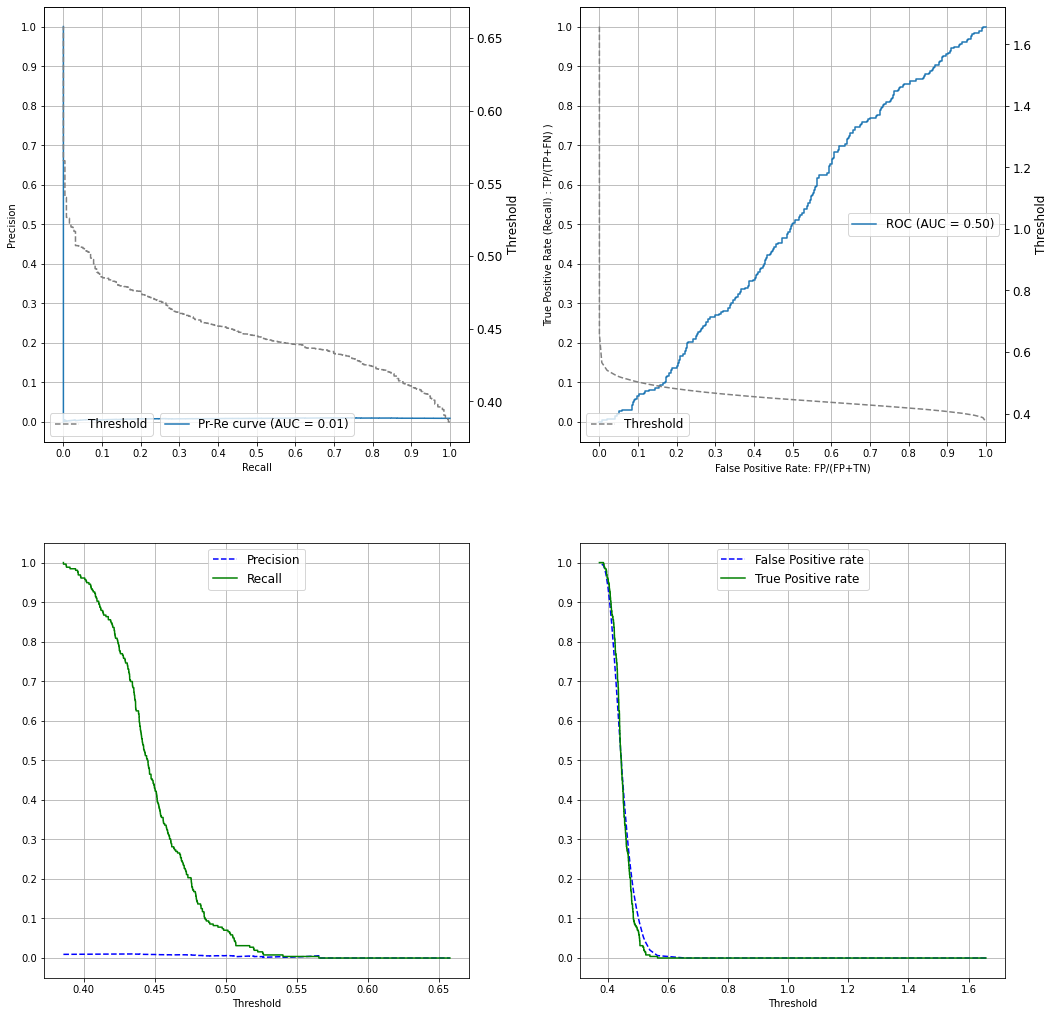

time: 1.53 s (started: 2022-02-21 06:30:17 +00:00)


In [14]:
evaluate_anomaly_detector(y_train, anomaly_scores)

# Increasing the Number of trees

In [15]:
model = IsolationForest(n_estimators=500)
model.fit(X_train)

IsolationForest(n_estimators=500)

time: 2.21 s (started: 2022-02-21 06:30:19 +00:00)


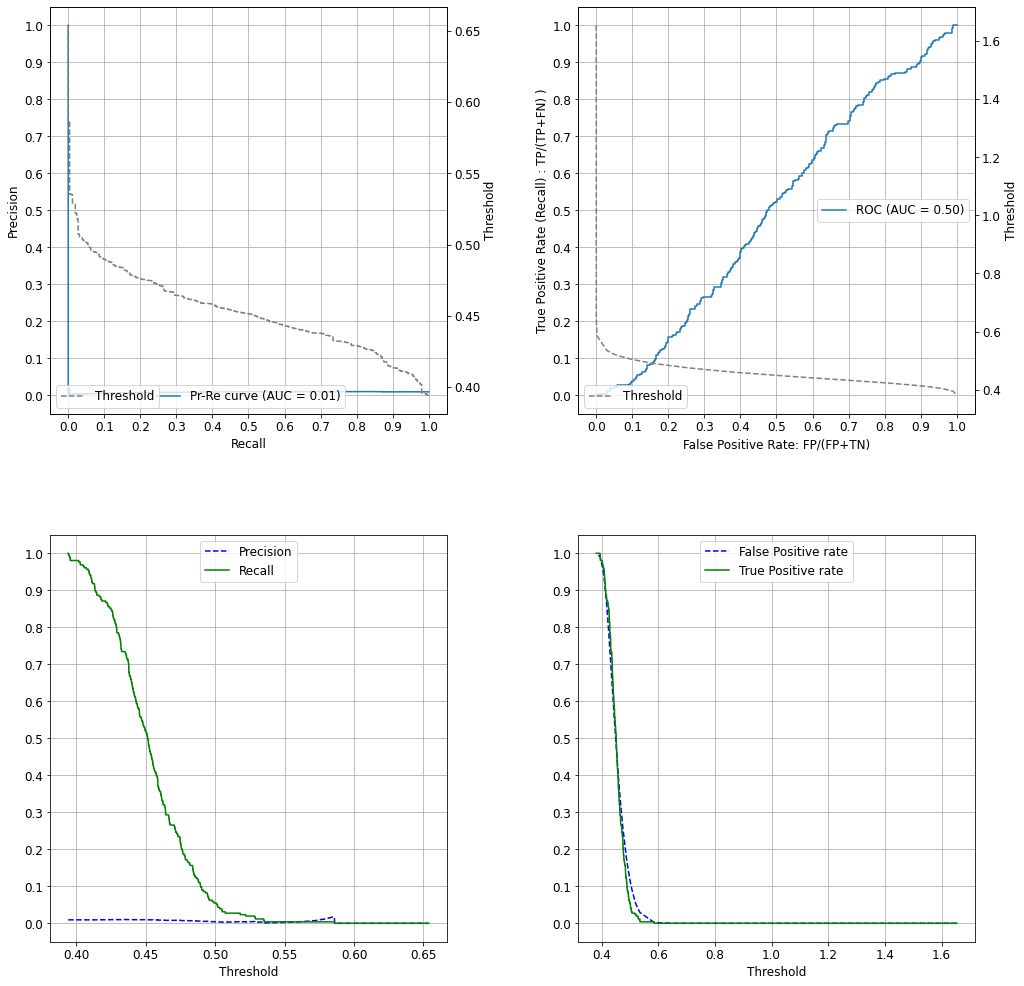

time: 10.8 s (started: 2022-02-21 06:30:21 +00:00)


In [16]:
anomaly_scores = 0.5 - model.decision_function(X_train)
evaluate_anomaly_detector(y_train, anomaly_scores)

# GridSearch with Same Number of Trees of the last result

In [17]:
iforest = IsolationForest(n_estimators=500)

for max_features in [1, 5, 11]:
  for max_samples in range(256, X_train.shape[0], int(X_train.shape[0] / 3) ):
    model = IsolationForest(n_estimators=500, max_features=max_features,
                            max_samples = max_samples)
    model.fit(X_train)
    anomaly_scores = 0.5 - model.decision_function(X_train)
    auc_score = average_precision_score(y_train, anomaly_scores)
    print("max_fetaures:", max_features, "; max_samples:", max_samples, 
          "auc_score:", auc_score)

max_fetaures: 1 ; max_samples: 256 auc_score: 0.009046069921522511
max_fetaures: 1 ; max_samples: 9460 auc_score: 0.008459200748790318
max_fetaures: 1 ; max_samples: 18664 auc_score: 0.008235670082263771
max_fetaures: 5 ; max_samples: 256 auc_score: 0.009085627701053008
max_fetaures: 5 ; max_samples: 9460 auc_score: 0.008728144582672976
max_fetaures: 5 ; max_samples: 18664 auc_score: 0.00875617310122303
max_fetaures: 11 ; max_samples: 256 auc_score: 0.008983610303366807
max_fetaures: 11 ; max_samples: 9460 auc_score: 0.008681829662164792
max_fetaures: 11 ; max_samples: 18664 auc_score: 0.008624921562771814
time: 1min 14s (started: 2022-02-21 06:30:32 +00:00)


In [18]:
model = IsolationForest(n_estimators=500, max_features=max_features,
                        max_samples=max_samples)

model.fit(X_train)

IsolationForest(max_features=11, max_samples=18664, n_estimators=500)

time: 3.97 s (started: 2022-02-21 06:31:47 +00:00)


In [19]:
anomaly_scores = 0.5 - model.decision_function(X_train)

time: 6.7 s (started: 2022-02-21 06:31:51 +00:00)


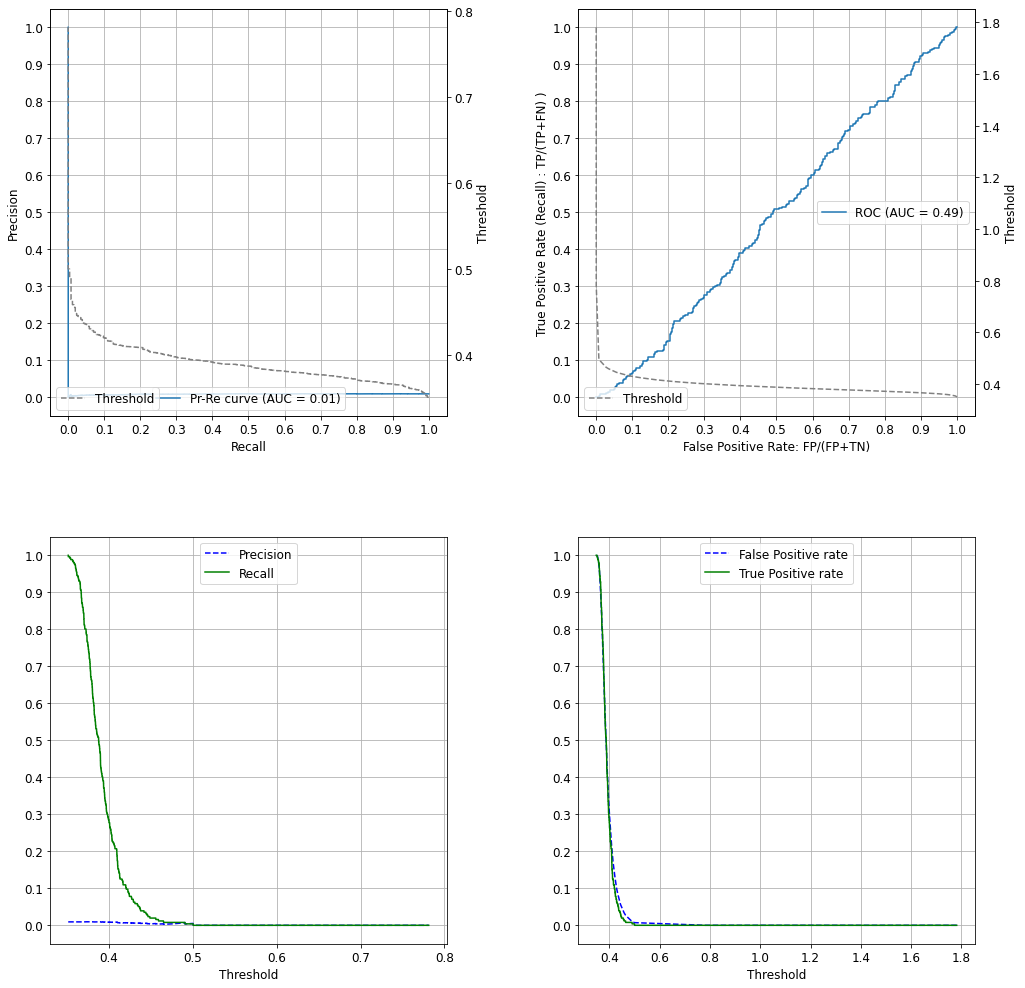

time: 1.17 s (started: 2022-02-21 06:31:57 +00:00)


In [20]:
evaluate_anomaly_detector(y_train, anomaly_scores)

# Increasing Number of Trees

In [21]:
n_estimators = 1500

model = IsolationForest(n_estimators=n_estimators, max_features=max_features,
                        max_samples=max_samples)

model.fit(X_train)

IsolationForest(max_features=11, max_samples=18664, n_estimators=1500)

time: 12 s (started: 2022-02-21 06:31:59 +00:00)


In [22]:
anomaly_scores = 0.5 - model.decision_function(X_train)

time: 20.5 s (started: 2022-02-21 06:32:11 +00:00)


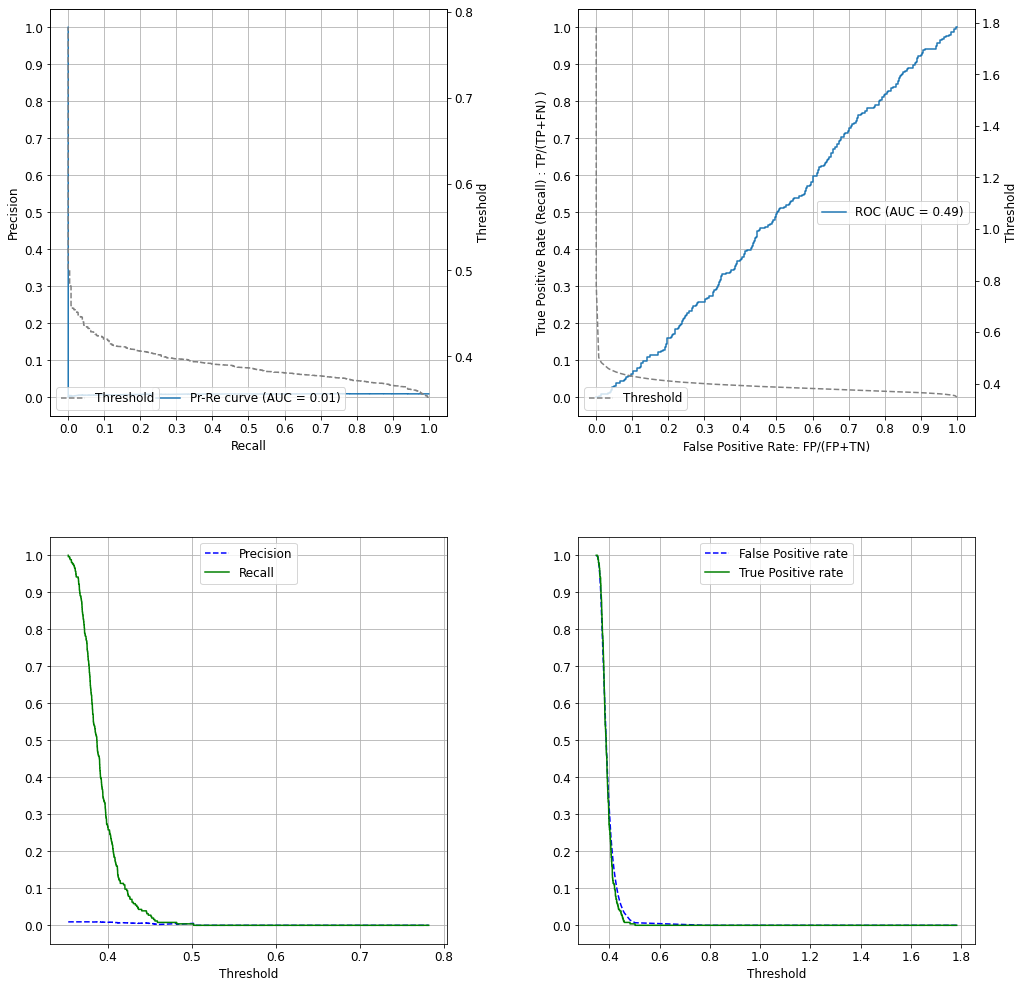

time: 1.16 s (started: 2022-02-21 06:32:31 +00:00)


In [23]:
evaluate_anomaly_detector(y_train, anomaly_scores)

Choosing the threshold

Precision= 0.00945761668059649
Recall= 0.83984375
False Positive Rate =  0.8231466588682556
True Positive Rate =  0.83984375


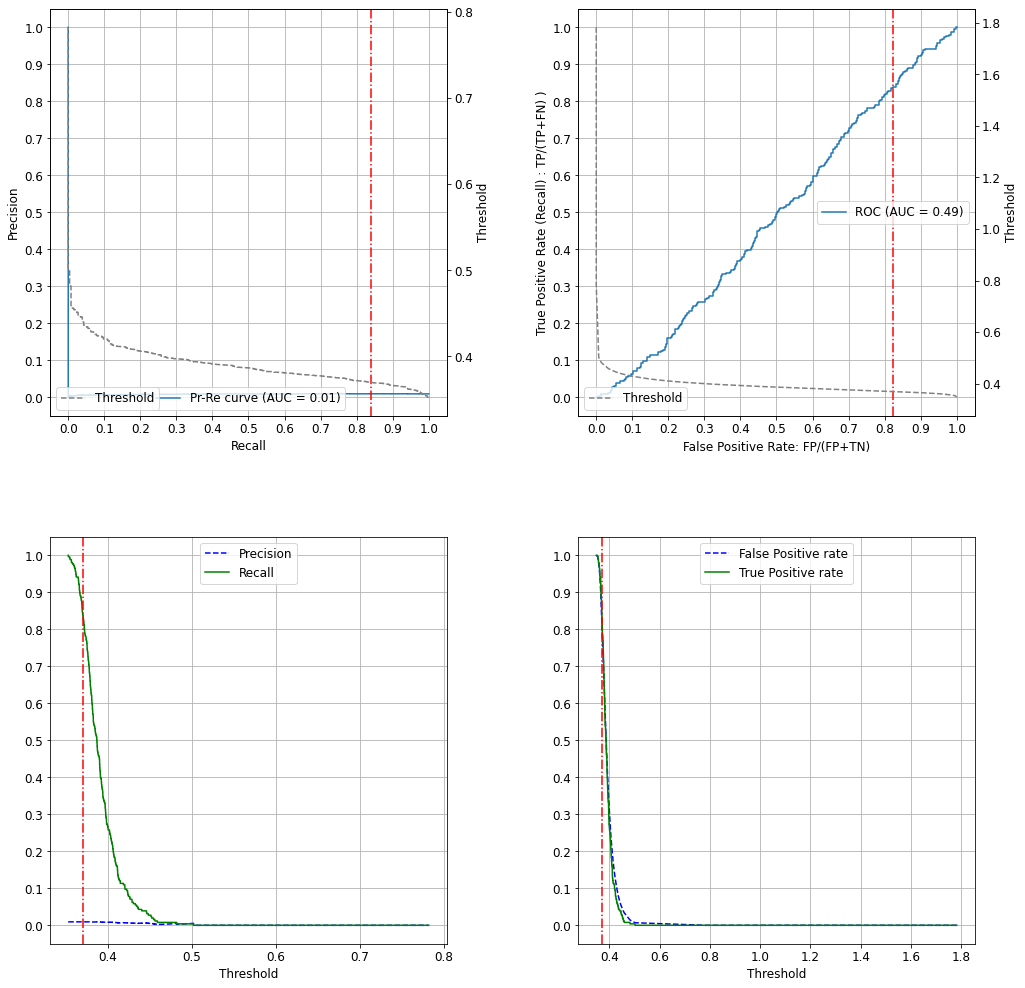

time: 1.39 s (started: 2022-02-21 06:32:32 +00:00)


In [24]:
threshold_selected = 0.37

evaluate_anomaly_detector(y_train, anomaly_scores, threshold_selected)

# Test the model

In [25]:
model.fit(X_test)
an_scores = 0.5 - model.decision_function(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_iforest.py:293: UserWarning: max_samples (18664) is greater than the total number of samples (6903). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples)


time: 9.63 s (started: 2022-02-21 06:32:34 +00:00)


In [26]:
y_pred = (an_scores >= threshold_selected)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)

print("precision=", precision)
print('recall=', recall)
print('false positive rate=', fpr)

precision= 0.007243096423721141
recall= 0.9795918367346939
false positive rate= 0.9598774438284213
time: 21.1 ms (started: 2022-02-21 06:32:43 +00:00)


Normalized confusion matrix
[[0.04012256 0.95987744]
 [0.02040816 0.97959184]]


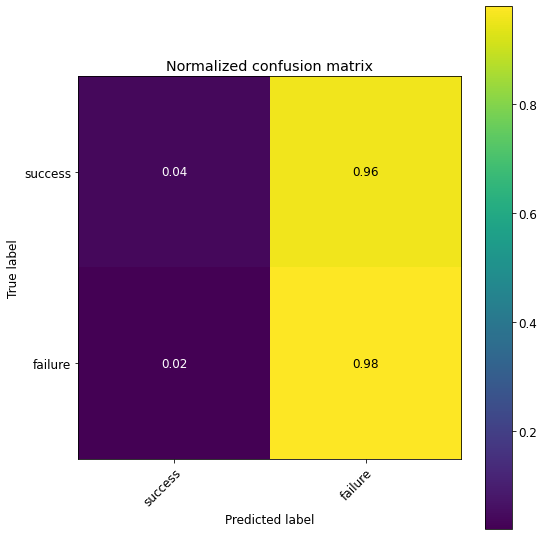

time: 300 ms (started: 2022-02-21 06:32:43 +00:00)


In [27]:
class_names= np.array( ['success', 'failure'] )
plot_conf_mat(y_test, y_pred, class_names)